D:\anaconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


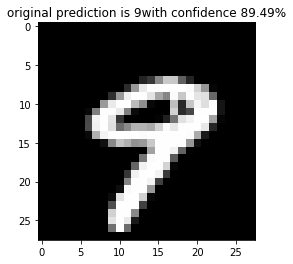

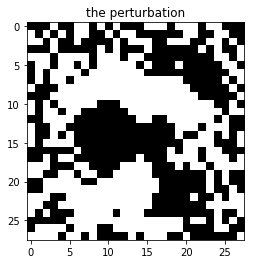

D:\anaconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


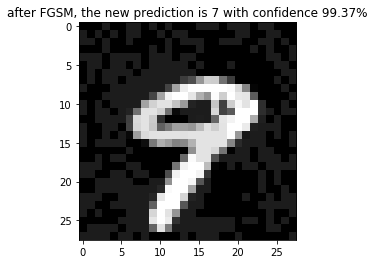

In [11]:
from models import FC3
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

epson = 0.2 #对抗样本强度
index = 9 #展示不同的图片
size = 28*28
classes = 10

model = FC3()
model.load_state_dict(torch.load('FC3.pkl'))

test_set = dataset.MNIST(root='../data',
                         train=False,
                         transform=transforms.Compose([transforms.ToTensor(),
                                                       transforms.Normalize((0.1307,),(0.3081,))]),
                         download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1, shuffle=False)

i = 0
for image, label in test_loader:
    if i==index:
        # 预测
        image = image.reshape(-1, size)
        image.requires_grad_()
        output = model(image)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, label)
        prob = F.softmax(output)[0][label.item()]*100
        _, predicted = torch.max(output.data, 1)
        
        plt.figure()
        plt.imshow(image.reshape(28, 28).detach().numpy(), cmap='gray')
        plt.title('original prediction is '+str(predicted.item())+'with confidence {:.2f}%'.format(prob.item()))
        plt.show()
        
        # FGSM生成对抗样本
        loss.backward()
        pert = epson*image.grad.sign()
        plt.imshow(pert.reshape(28, 28).detach().numpy(), cmap='gray')
        plt.title('the perturbation')
        plt.show()
        
        # 测试对抗样本效果
        new = image+epson*image.grad.sign()
        new_output = model(new.reshape(-1, size))
        new_loss = criteria(new_output, label)
        _, new_pred = torch.max(new_output.data, 1)
        new_prob = F.softmax(new_output)[0][new_pred.item()]*100

        plt.figure()
        plt.imshow(new.reshape(28, 28).detach().numpy(), cmap='gray')
        plt.title('after FGSM, the new prediction is '+str(new_pred.item())+' with confidence {:.2f}%'.format(new_prob.item()))
        plt.show()
        
        break
        
    i += 1